In [1]:
import sys

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np

from hubbard.hubbard import *
from hubbard.utilities import * 

In [2]:
tex_fonts = {
    "pgf.texsystem": "pdflatex",
    'pgf.rcfonts': False,
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [3]:
def params_calc(M, phi):
    j = np.arange(M)+1
    p_j = lambda q: np.sqrt(2/M) * np.cos(np.pi / M * q * (j-.5))
    a_j = lambda phi, phi_0: 1/np.sqrt(M) * np.exp(1j* (phi * j + phi_0))
    q = np.arange(M-1)+1
    Eq = np.cos(np.pi/M*q)-1
    E_gap_min = abs(np.cos(np.pi / M) - 1) 
    Omega = E_gap_min / 10
    A = np.empty(len(phi), dtype = np.complex64)
    fqp = np.empty((len(q), len(phi)), dtype = np.complex64)
    for i, q_i in enumerate(q):
        for k, phi_k in enumerate(phi):
            #phi_0 = 0
            phi_0 = -(M+1)/2 * phi_k
            #phi_0 = - 1/2 * phi_k
            fqp[i, k] = sum(p_j(q_i)*a_j(phi_k, phi_0))
            A[k] = sum(a_j(phi_k, phi_0))

    F_diag = abs(fqp)**2
    F_diag = [sum(F_diag[:,i] / Eq) for i in range(len(phi))]
    F_diag = np.array(F_diag)

    F_off = np.conj(fqp)**2
    F_off_2 = fqp**2

    #print(F_off.real == F_off_2.real)

    F_off = [sum(F_off[:,i] / Eq) for i in range(len(phi))]
    F_off = np.array(F_off)

    #print('Max Im[F_off]:', abs(F_off.imag).max())
    #print('Min Im[F_off]:', abs(F_off.imag).min())

    chi_z = Omega **2 / 2/(M-1) * F_diag
    chi_x = Omega **2 / 2/(M-1) * np.real(F_off)
    chi_xy = Omega **2 / 2/(M-1) * np.imag(F_off)

    A = A/M

    v_x = A.real * Omega / 2
    v_y = A.imag * Omega / 2
    
    return chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off

In [4]:
N = M = 200

spin = SpinModel(N, M, bc = 'open')

In [6]:
#spin.set_scheme('parallel')
spin.set_scheme('multiply')

(0.0, 1.1)

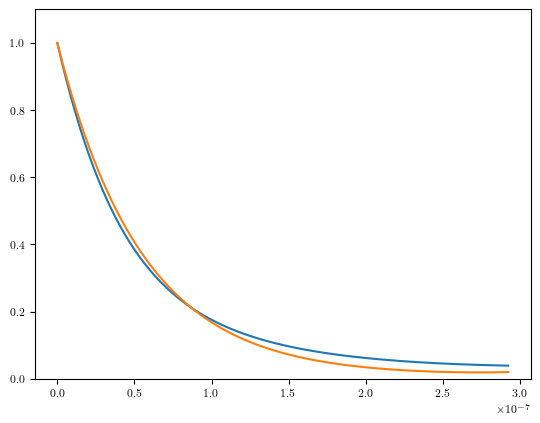

In [7]:
chi = 1e5
N_steps = 500
spin.S_calc()
spin.H = chi*spin.Sx**2
t, sq = spin.evolve(spin.initial_state(), t_f = N**(-2/3)/chi, num = N_steps, parameters = ['squeezing'])
OAT_L = sq.min()

plt.plot(t, sq[0])

spin.H = chi*(spin.Sx**2-spin.Sy**2)
_, sq = spin.evolve(spin.initial_state(), t_f = np.log(N)/(2*N)/chi, num = N_steps, parameters = ['squeezing'])
TACT_L = sq.min()

plt.plot(t, sq[0])

plt.ylim(0, 1.1)

In [26]:
n_x = 50

In [27]:
def best_sq_calc(phi_list, N_steps = 100):
    J_SE = 1
    
    E_gap = J_SE*abs(np.cos(np.pi/M)-1)
    Omega = E_gap/10
    print('E_gap:', E_gap)
    print('Omega:', Omega)
    
    ini_label = ['x','y','z']
    psi_list = [0, np.pi/2, 0]
    theta_list = [np.pi/2, np.pi/2, 0]

    std_lim = np.std(1-0.001*(.5-np.random.rand(N_steps)))
    
    full_data = []
    t_best = np.empty((len(phi_list), len(theta_list)))
    xi_best = np.empty((len(phi_list), len(theta_list)))
    wf0 = [spin.rotate((theta, psi), spin.initial_state()) for theta, psi in zip(theta_list, psi_list)]
    for i, phi in enumerate(phi_list):
        spin.H = spin.H_eff_open(J_SE, Omega, phi, phi_0 = -(M+1)/2*phi)

        _, _, _, chi_x, chi_z, _ = open_coeff(phi, N, M, J_SE, Omega, phi_0 = -(M+1)/2*phi)
        chi = chi_z + chi_x
            
        for j in range(len(theta_list)):
            t_f = 1/abs(chi)

            t = [0]
            sq = [1]
            wf = wf0[j]
            search = True
            end = 3#N_steps // 10
            while search:
                t_new, data = spin.evolve(wf, t_f = t_f, num = N_steps, 
                                          parameters = ['squeezing'], save_wf = True)
                wf = spin.wf_t[-1]
                t = np.concatenate((t, t_new+t[-1]))
                sq = np.concatenate((sq, data[0]))
                
                first_passage = sq > sq[2]
                first_passage[:end] = False
                t_f += t_f
                if any(first_passage):
                    t_1pass = t[first_passage][0]
                    mask = t < t_1pass
                    '''
                    if t_1pass < 1 / abs(chi) / 10:
                        print('Squeezing too fast!')
                        second_passage = [i for i in range(1, len(first_passage)) 
                                          if first_passage[i-1] == True and first_passage[i] == False]
                        second_passage = second_passage[0]
                        end = second_passage + 3
                        print(end, i, j)
                    el
                    '''
                    if len(t[mask]) < N_steps:
                    #if len(t[mask]) < (N_steps // 2):
                        t = [0]
                        sq = [1]
                        wf = wf0[j]
                        t_f = t_1pass
                    else:
                        search = False
                        t = t[mask]
                        sq = sq[mask]
                elif sq.std() < std_lim:
                    search = False

            t_best[i, j], xi_best[i, j] = calc_minima(t, sq)
            full_data.append((t, sq))
        
    return full_data, t_best, xi_best, ini_label

In [5]:
def plot_evo_full(full_data, t_best, ini, lim = None):
    fig, ax = plt.subplots()
    t_all = t_best[:, ini]
    if lim is None:
        lim = np.nanmax(t_all)
    for t, sq in full_data[ini::3]:
        if t[sq.argmin()] < lim:
            ax.plot(t, sq)

    ax.set_ylim(0., 1.1)
    ax.set_xlim(0,lim)
    
    return fig, ax

In [9]:
#figwidth = 3.416*2#*.45
def plot_opt_sq(x, t_best, xi_best, label, phi_crit = None):
    fig, axs = plt.subplots(2, 1, 
                                   sharex = 'col',
                                   constrained_layout=True, 
                                   figsize=(10, 10)
                                   )
    phi = np.copy(x)
    phi /= 2*np.pi/N
    if phi_crit is not None:
        phi_crit /= 2*np.pi/N
    axs[-1].set_xlabel(r'$\phi\ \left[\frac{2\pi}{N}\right]$')
    axs[-2].set_ylabel(r'$\xi^2_\mathrm{best}$')
    axs[-1].set_ylabel('$t_\mathrm{best}$')
    x_ticks = [phi[0], phi_crit, phi[-1]] if phi_crit is not None else [phi[0], phi[len(phi)//2], phi[-1]]
    axs[-1].set_xticks(x_ticks)

    markers = '.', '1', '2'
    for j in range(len(ini_label)):
        #axs[-2].scatter(phi, xi_best[:, j], marker = markers[j], label = ini_label[j])
        #axs[-1].scatter(phi,  t_best[:, j], marker = markers[j], label = ini_label[j])
        axs[-2].plot(phi, xi_best[:, j], label = ini_label[j])
        axs[-1].plot(phi,  t_best[:, j], label = ini_label[j])

    #axs[-1].legend()
    
    axs[-2].axhline(TACT_L, color = 'tab:red', alpha = 0.5)
    axs[-2].axhline(OAT_L, color = 'tab:purple', alpha = 0.5)

    axs[-1].set_yscale("log")
    axs[-2].set_yscale('log')
    
    if phi_crit is not None:
        for ax in axs:
            ax.axvline(phi_crit, color = 'tab:grey', ls = 'dashed')
            
    colwidth = 3.416666
    fig.set_size_inches(w = colwidth, h = 1.3*colwidth)

    fig.savefig(f'output/best_sq_{label}_N{N}.pdf', format='pdf', bbox_inches='tight')

    fig.set_size_inches(w = 10, h = 10)
            
    return fig, axs

# Squeezing for commensurate phases

In [30]:
phi = 2*np.pi/M*(np.arange(M-1)+1)

In [99]:
chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off = params_calc(M, phi)

eta = chi_x / chi_z
gamma = v_x / chi_z

In [32]:
full_data, t_best, xi_best, ini_label = best_sq_calc(phi)

E_gap: 0.00012336751833941229
Omega: 1.233675183394123e-05


/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 2.221886744113211e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -4.4280816334024364e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 4.467677401159139e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 2.2153771484052166e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWa

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -4.4579198340409375e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 4.415011441799495e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -4.414635536596043e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -4.44751279508342e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWa

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 4.451270463337483e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 2.219498101479866e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 4.4741560985704546e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -2.2035559803773126e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWa

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 86706.28066784782
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -38522.91891921341
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 40584.37096210303
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -40510.094855769195
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -50505.3855552439
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -52080.85636150784
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -20253.00265310687
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 3558.8572288793735
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -0.14165445417943143
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 0.00010634019931319436
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -258.19916303577804
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -0.01550377012738794
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning:

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -1195.6179809574476
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 290642.7499825074
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 179671.3962372841
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -495.2910375249783
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 4.627588299999409
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 0.059045933186776894
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 0.3682408886067085
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -0.03916221991805949
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squee

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -4.442652117556943e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 8.929759389172476e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -4.453632997632235e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 2.2143942506391002e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWa

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -4.426975457924281e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 8.905408200718842e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -2.216285268324221e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 4.4554208166170305e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWa

In [92]:
data = {'phi': phi, 't_best': t_best, 'xi_best': xi_best, 
        'eta': eta, 'gamma': gamma, 'full_data': full_data}
np.savez(f'output/comm_sq_N{N}', **data)

In [10]:
data = np.load(f'output/comm_sq_N{N}.npz', allow_pickle = True)

data['t_best']

array([[1.09594756e+07, 4.20505545e+06, 5.98442426e+06],
       [4.38270869e+07, 1.68160719e+07, 2.39317911e+07],
       [9.85703973e+07, 3.78206038e+07, 5.38243888e+07],
       [1.75135382e+08, 6.71979223e+07, 9.56327168e+07],
       [2.73446480e+08, 1.04919035e+08, 1.49315515e+08],
       [3.93406671e+08, 1.50946717e+08, 2.14819806e+08],
       [5.34897569e+08, 2.05235543e+08, 2.92080944e+08],
       [6.97779538e+08, 2.67731938e+08, 3.81022682e+08],
       [8.81891835e+08, 3.38374224e+08, 4.81557245e+08],
       [1.08705276e+09, 4.17092687e+08, 5.93585418e+08],
       [1.31305985e+09, 5.03809640e+08, 7.16996642e+08],
       [1.55969006e+09, 5.98439505e+08, 8.51669125e+08],
       [1.82669999e+09, 7.00888894e+08, 9.97469963e+08],
       [2.11382614e+09, 8.11056700e+08, 1.15425527e+09],
       [2.42078516e+09, 9.28834203e+08, 1.32187031e+09],
       [2.74727410e+09, 1.05410517e+09, 1.50014967e+09],
       [3.09297076e+09, 1.18674597e+09, 1.68891742e+09],
       [3.45753399e+09, 1.32662

In [11]:
plot_evo_full(full_data, t_best, ini = 1)

NameError: name 'full_data' is not defined

(1000000000.0, 50000000000.0)

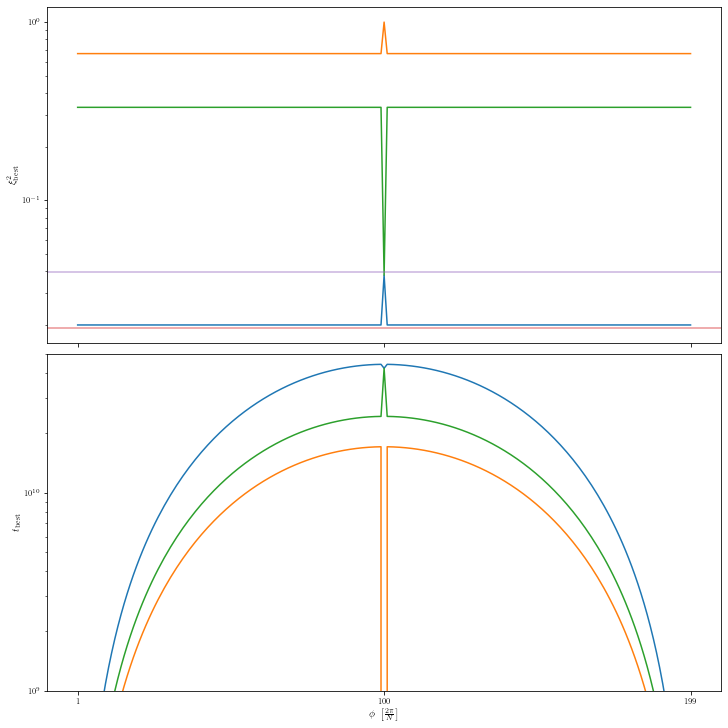

In [97]:
#t_best[M//2-1, 1] = 0
fig, axs = plot_opt_sq(phi, t_best, xi_best, label = 'comm')

axs[1].set_ylim((1e9, 5e10))

In [15]:
N = 200
data = np.load(f'output/comm_sq_N{N}.npz', allow_pickle = True)

chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off = params_calc(N, data['phi'])

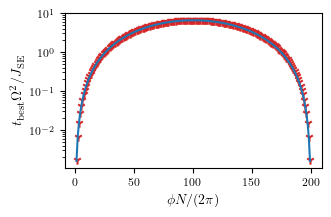

In [36]:
fig, ax1 = plt.subplots()

x = data['phi'] / (2*np.pi/N)

ax1.set_xlabel('$\phi N / (2\pi)$')

color = 'tab:green'
#ax1.scatter(x, data['xi_best'][:,0], marker = '2', color = color, zorder = 100)
#ax1.set_ylabel(r'$\xi^2_\mathrm{best}$', color = color)
#ax1.set_yscale('log')
#ax1.tick_params(axis='y', labelcolor=color)

#ax2 = ax1.twinx()
ax2 = ax1

y = 2*np.sqrt(2)*np.log(N/2)/abs(F_diag)
y /= 2
#print(y)

color = 'tab:red'
J_SE = 1
E_gap_min = J_SE*(1-np.cos(np.pi/N))
Omega = E_gap_min/10

ax1.plot(x, y)
ax2.scatter(x, Omega**2/J_SE*data['t_best'][:,0], marker = '1', color = color)
ax2.set_ylabel(r'$t_\mathrm{best}\Omega^2/J_\mathrm{SE}$')#, color = color)
ax2.set_yscale('log')
#ax2.tick_params(axis='y', labelcolor=color)

colwidth = 3.416666
fig.set_size_inches(w = colwidth, h = colwidth*2/3)

fig.tight_layout()
fig.savefig(f'output/best_sq_comm_N{N}.pdf', format='pdf', bbox_inches='tight')

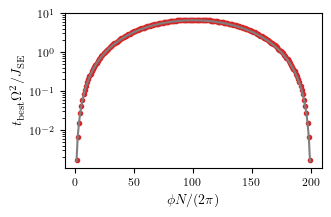

In [69]:
fig, ax = plt.subplots()

x = data['phi'] / (2*np.pi/N)

ax.set_xlabel('$\phi N / (2\pi)$')

y = 2*np.sqrt(2)*np.log(N/2)/abs(F_diag)
y /= 2

color = 'tab:red'
J_SE = 1
E_gap_min = J_SE*(1-np.cos(np.pi/N))
Omega = E_gap_min/10

ax.plot(x, y, color = 'tab:gray')
ax.scatter(x, Omega**2/J_SE*data['t_best'][:,0], marker = '.', color = color)
ax.set_ylabel(r'$t_\mathrm{best}\Omega^2/J_\mathrm{SE}$')#, color = color)
ax.set_yscale('log')

colwidth = 3.416666
fig.set_size_inches(w = colwidth, h = colwidth*2/3)

fig.tight_layout()
fig.savefig(f'output/best_sq_comm_N{N}.pdf', format='pdf', bbox_inches='tight')

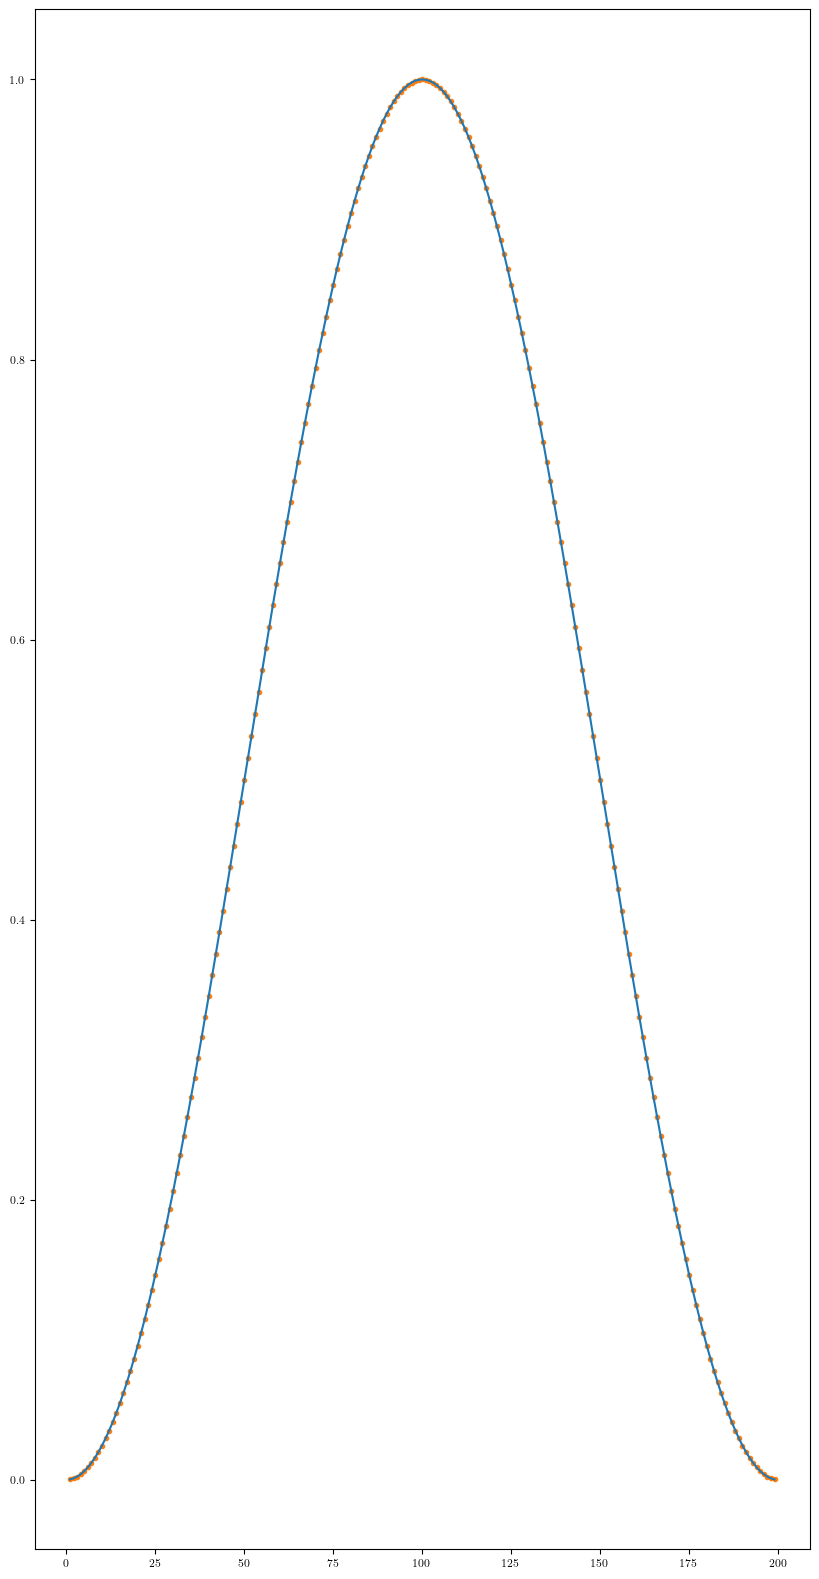

In [75]:
fig = plt.figure()
fig.set_size_inches(10, 20)

plt.plot(x, abs(1/F_diag))
x_m = x.mean()
sigma = x.std()*2/3
#plt.plot(x, np.exp(-(x-x_m)**2/sigma**2/2))
#plt.scatter(x, np.sin(2*np.pi/N*x/2)**2, marker = '.', color = 'tab:orange')
plt.scatter(x, .5*(1-np.cos(2*np.pi/N*x)), marker = '.', color = 'tab:orange')